In [2]:
print(2)

2


In [3]:
# import psycopg2

import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import xgboost as xgb
# import lightgbm as lgb
# from catboost import CatBoostRegressor

import joblib
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Subset, DataLoader

from Dataset.Embedding_Dataset import Embedding_Dataset
from Model.Embedding import Embedding

from Dataset.Apartment_Complex_Dataset import Apartment_Complex_Dataset
from Model.LSTM import LSTM
from Model.GRU import GRU
from Model.Transformer import Transformer
from Model.Informer import Informer
from Model.Pyraformer import Pyraformer
from Model.N_BEATS import NBeats
from Model.NLinear import NLinear

from Dataset.District_Dataset import District_Dataset 
from Model.LSTM_Attention import LSTMAttention
from Model.GRU_Attention import GRUAttention
from Model.Transformer_Attention import TransformerAttention
from Model.Informer_Attention import InformerAttention

from utils import r2, rmse, mse, mae, save_train_val_losses

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

table_1 = pd.read_csv('../데이터/Table/table_1.csv') 
table_2 = pd.read_csv('../데이터/Table/table_2.csv') 
table_3 = pd.read_csv('../데이터/Table/table_3.csv') 

In [5]:
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

lr = 1e-4
batch = 64
hidden_dim = 1024
embedding_dim = 1024
sub = True
embedding_dim = 1024
window_size = 12

### DL

In [6]:
table_1['dong'] = table_1['location'].str.split().str[2]
table_1_sang = table_1[table_1['dong'] == '상계동']
table_1_su = table_1[table_1['dong'] == '수송동']

In [11]:
embedding_model = torch.load("../데이터/Checkpoint/embedding/default/embedding_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_13.pth", map_location=DEVICE, weights_only=False)
dataset = District_Dataset(embedding_model, table_1, table_2, table_3, embedding_dim, window_size, sub, DEVICE)
dataset_length = len(dataset)
train_size = int(train_ratio * dataset_length)
# train_indices = range(0, train_size)
val_size = int(val_ratio * dataset_length)
# val_indices = range(train_size, train_size + val_size)
test_size = int(test_ratio * dataset_length)
test_indices = range(train_size + val_size, dataset_length)
# train_dataset = Subset(dataset, train_indices)
# val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)
# train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False, drop_last=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True)

ValueError: could not convert string to float: '개포동'

In [4]:
model_name = 'transformer_attention'

In [5]:
if model_name == "lstm":
    model = torch.load("../데이터/Checkpoint/lstm/lstm_lr_0.0001_batch_64_hid_1024_sub_True_emb_1024_ws_12_epochs_17.pth", map_location=DEVICE, weights_only=False)
elif model_name == "gru":
    model = torch.load("../데이터/Checkpoint/gru/gru_lr_0.0001_batch_64_hid_1024_sub_True_emb_1024_ws_12_epochs_15.pth", map_location=DEVICE, weights_only=False)
elif model_name == "transformer":
    model = torch.load("../데이터/Checkpoint/transformer/transformer_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_26.pth", map_location=DEVICE, weights_only=False)
elif model_name == "informer":
    model = torch.load(f'../데이터/Checkpoint/informer/informer_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_27.pth', map_location=DEVICE, weights_only=False)
elif model_name == "pyraformer":
    model = torch.load(f'../데이터/Checkpoint/pyraformer/pyraformer_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_11.pth', map_location=DEVICE, weights_only=False)
elif model_name == "nbeats":
    model = torch.load(f'../데이터/Checkpoint/n_beats/n_beats_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_25.pth', map_location=DEVICE, weights_only=False)
elif model_name == "nlinear":
    model = torch.load(f'../데이터/Checkpoint/nlinear/nlinear_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_29.pth', map_location=DEVICE, weights_only=False)
elif model_name == "lstm_attention":
    model = torch.load("../데이터/Checkpoint/lstm_attention/lstm_attention_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_16.pth", map_location=DEVICE, weights_only=False)
elif model_name == "gru_attention":
    model = torch.load("../데이터/Checkpoint/gru/attention/gru_attention_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_4.pth", map_location=DEVICE, weights_only=False)
elif model_name == "transformer_attention":
    model = torch.load("../데이터/Checkpoint/transformer_attention/transformer_attention_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_37.pth", map_location=DEVICE, weights_only=False)
elif model_name == "informer_attention":
    model = torch.load("../데이터/Checkpoint/informer_attention/informer_attention_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_5.pth", map_location=DEVICE, weights_only=False)
elif model_name == "pyraformer_attention":
    model = torch.load("../데이터/Checkpoint/pyraformer_attention/pyraformer_attention_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_X.pth", map_location=DEVICE, weights_only=False)

In [71]:
import pickle

model.eval()
test_rmses = []
test_mses = []
test_maes = []
test_r2s = []

test_outputs = []
test_trgs = []

with torch.no_grad():
    for batch_idx, data in enumerate(test_dataloader):
        batch_size = len(data[0])  # 배치 내 동의 개수
        
        # 배치 내 모든 동에 대해 처리
        for district_idx in range(batch_size):
            src = data[0][district_idx].to(DEVICE)  # shape: [max_apartments, window_size, embedding_dim]
            max_len = data[1][district_idx].to(DEVICE)
            try:
                anw = torch.nonzero(data[2][district_idx]).squeeze()
                if anw.dim() == 0:  # 단일 원소인 경우
                    anw = anw.unsqueeze(0)
            except:
                continue
            trg = data[3][district_idx].to(DEVICE)

            # 해당 동의 모든 아파트 단지에 대해 예측
            for index in anw:
                # 모델별 처리
                if model_name == "lstm":
                    apartment_src = src[index].unsqueeze(0)  # [1, window_size, embedding_dim]
                    output, _, _ = model(apartment_src)
                elif model_name == "gru":
                    apartment_src = src[index].unsqueeze(0)  # [1, window_size, embedding_dim]
                    output, _ = model(apartment_src)
                elif model_name == "transformer":
                    apartment_src = src[index].unsqueeze(0)  # [1, window_size, embedding_dim]
                    src_mask = model.generate_square_subsequent_mask(apartment_src.shape[1]).to(apartment_src.device)
                    output, _ = model(apartment_src, src_mask)
                elif model_name == "informer":
                    apartment_src = src[index].unsqueeze(0)  # [1, window_size, embedding_dim]
                    output, _ = model(apartment_src)
                elif model_name == "pyraformer":
                    apartment_src = src[index].unsqueeze(0)  # [1, window_size, embedding_dim]
                    output, _ = model(apartment_src)
                elif model_name == "nbeats":
                    apartment_src = src[index].unsqueeze(0)  # [1, window_size, embedding_dim]
                    output = model(apartment_src.view(apartment_src.size(0), -1))
                elif model_name == "nlinear":
                    apartment_src = src[index].unsqueeze(0)  # [1, window_size, embedding_dim]
                    output = model(apartment_src)
                elif model_name.endswith("_attention"):
                    # attention 모델은 전체 src를 사용하고 배치 차원 추가 없음
                    output = model(src, index, max_len)

                # 결과 저장
                if model_name.endswith("_attention"):
                    test_outputs.append(output.item())
                    test_trgs.append(trg[index].item())
                else:
                    test_outputs.append(output[0].item())
                    test_trgs.append(trg[index].item())

test_outputs = torch.FloatTensor(test_outputs)
test_trgs = torch.FloatTensor(test_trgs)  

test_rmse = rmse(test_outputs, test_trgs)
test_mse = mse(test_outputs, test_trgs)
test_mae = mae(test_outputs, test_trgs)
test_r2 = r2(test_outputs, test_trgs)

print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test MAE: {test_mae:.4f}')
print(f'Test R2: {test_r2:.4f}')

test_outputs_np = test_outputs.cpu().numpy()
test_trgs_np = test_trgs.cpu().numpy()

print(f"총 예측된 아파트 단지 수: {len(test_outputs_np)}")

save_path = f'../데이터/Checkpoint/{model_name}'
with open(f'{save_path}/test_outputs.pkl', 'wb') as f:
    pickle.dump(test_outputs_np, f)
with open(f'{save_path}/test_trgs.pkl', 'wb') as f:
    pickle.dump(test_trgs_np, f)

Test RMSE: 1.2970
Test MSE: 1.6822
Test MAE: 1.0545
Test R2: 0.6455
총 예측된 아파트 단지 수: 2385


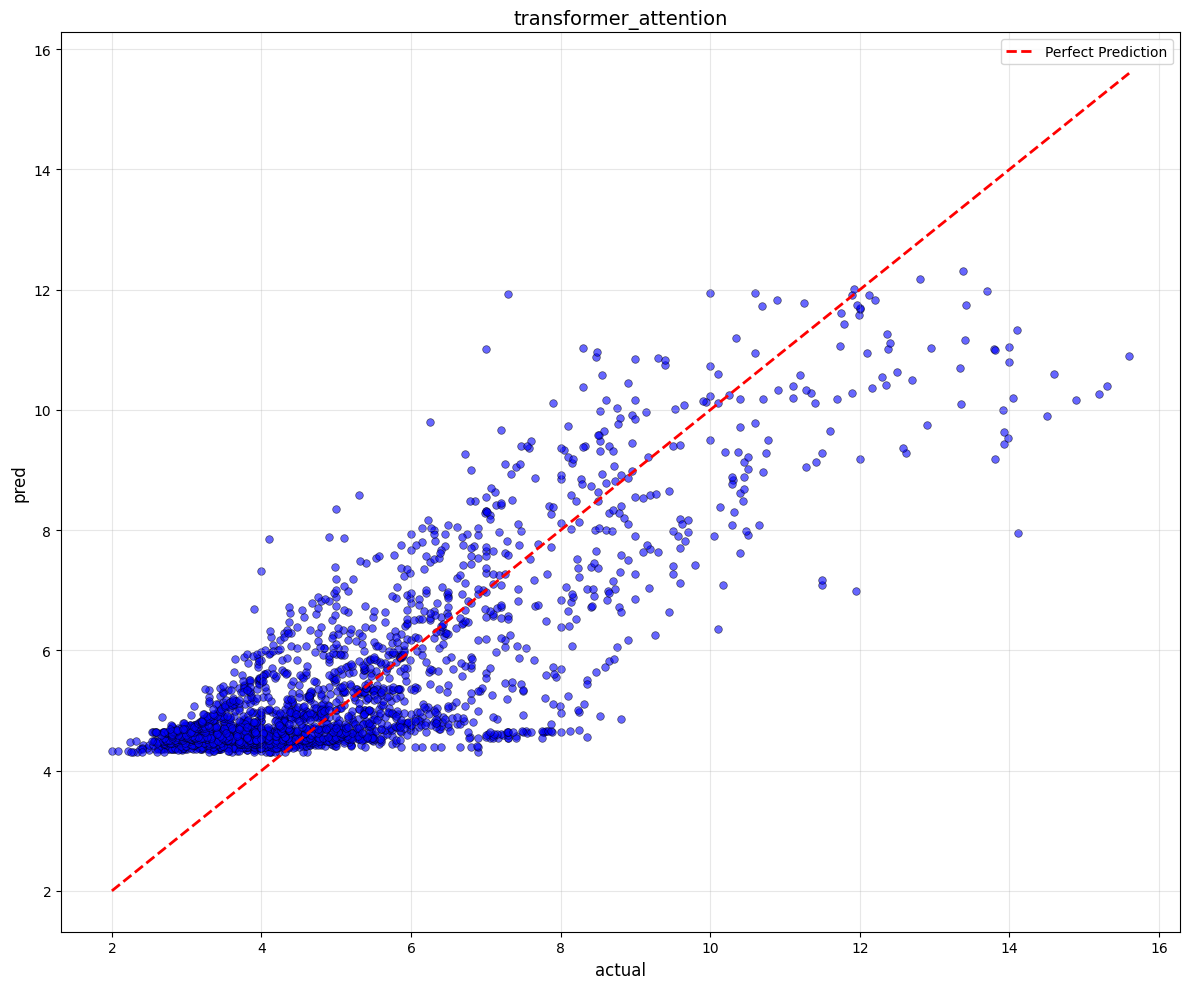


=== 예측 결과 통계 ===
총 아파트 단지 수: 2385
실제 가격 범위: 2.00 ~ 15.60 억원
예측 가격 범위: 4.31 ~ 12.31 억원
실제 가격 평균: 5.13 억원
예측 가격 평균: 5.48 억원


In [72]:
# 산점도 생성
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.scatter(test_trgs_np, test_outputs_np, alpha=0.6, s=30, c='blue', edgecolors='black', linewidth=0.5)
min_val = min(test_trgs_np.min(), test_outputs_np.min())
max_val = max(test_trgs_np.max(), test_outputs_np.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('actual', fontsize=12)
plt.ylabel('pred', fontsize=12)
plt.title(f'{model_name}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(f'{save_path}/apartment_scatter_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# 통계 정보
print(f"\n=== 예측 결과 통계 ===")
print(f"총 아파트 단지 수: {len(test_outputs_np)}")
print(f"실제 가격 범위: {test_trgs_np.min():.2f} ~ {test_trgs_np.max():.2f} 억원")
print(f"예측 가격 범위: {test_outputs_np.min():.2f} ~ {test_outputs_np.max():.2f} 억원")
print(f"실제 가격 평균: {test_trgs_np.mean():.2f} 억원")
print(f"예측 가격 평균: {test_outputs_np.mean():.2f} 억원")

### ML

In [22]:
embedding_model = torch.load('../데이터/Checkpoint/embedding/default/embedding_lr_0.0001_batch_64_sub_True_emb_1024_ws_12_epochs_13.pth', map_location=DEVICE)
dataset = Apartment_Complex_Dataset(embedding_model, table_1, table_2, table_3, embedding_dim, window_size, 'ML', DEVICE)
dataset_length = len(dataset)
train_size = int(train_ratio * dataset_length)
# train_indices = range(0, train_size)
val_size = int(val_ratio * dataset_length)
# val_indices = range(train_size, train_size + val_size)
test_size = int(test_ratio * dataset_length)
test_indices = range(train_size + val_size, dataset_length)
# train_dataset = Subset(dataset, train_indices)
# val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)
# train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=False, drop_last=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True)

In [26]:
# lightgbm
model = joblib.load(f'../데이터/Checkpoint/lightgbm/lightgbm_batch_64_ws_12.pkl')

# catboost
# model = joblib.load(f'../데이터/Checkpoint/catboost/catboost_batch_64_ws_12.pkl')

In [24]:
def rmse(y_pred, y_true):
      mse = np.mean((y_true - y_pred) ** 2)
      return np.sqrt(mse)

def mse(y_pred, y_true):
      return np.mean((y_true - y_pred) ** 2)

def mae(y_pred, y_true):
      return np.mean(np.abs(y_true - y_pred))

In [27]:
test_rmses = []
test_mses = []
test_maes = []

test_outputs = []
test_trgs = []

for data in test_dataloader:
    X, y = data[0].squeeze().cpu().numpy(), data[1].squeeze().cpu().numpy()
    y_pred = model.predict(X)

    test_outputs.append(y_pred)
    test_trgs.append(y)

save_path = f'../데이터/Checkpoint/lightgbm/lightgbm_batch_{batch}_ws_{window_size}'
with open(f'{save_path}_test_rmses.txt', 'w') as f:
    for item in test_rmses:
        f.write("%s\n" % item)
with open(f'{save_path}_test_mses.txt', 'w') as f:
    for item in test_mses:
        f.write("%s\n" % item)
with open(f'{save_path}_test_maes.txt', 'w') as f:
    for item in test_maes:
        f.write("%s\n" % item)

test_rmse = rmse(y_pred, y)
test_mse = mse(y_pred, y)
test_mae = mae(y_pred, y)

print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test MAE: {test_mae:.4f}')

Test RMSE: 20.7914
Test MSE: 432.2820
Test MAE: 20.7664
